# LSTM + GRU Hybrid Model for Stock Prediction

## Imports and Config

In [1]:
#cell 1: imports + seeds + device
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


## Loading the Data

In [2]:
#cell 2: project paths + load panel + filter AAPL
cwd = Path.cwd().resolve()
project_root = None
for p in [cwd] + list(cwd.parents):
    if (p / "data").exists():
        project_root = p
        break
if project_root is None:
    raise RuntimeError("Project root not found: missing /data folder")

DATA_DIR = project_root / "data"
PROC_DIR = DATA_DIR / "processed"

panel_path = PROC_DIR / "modeling_panel_targets.parquet"
print("project_root:", project_root)
print("panel_path:", panel_path)

df = pd.read_parquet(panel_path)
df["date"] = pd.to_datetime(df["date"])

df = df.sort_values(["ticker", "date"]).reset_index(drop=True)
df = df[df["ticker"] == "AAPL"].copy()
df = df.sort_values("date").reset_index(drop=True)

df.columns = (
    pd.Index(df.columns)
    .str.replace("_logret_laglogret_lag", "_logret_lag", regex=False)
)

cols_to_drop = [c for c in df.columns if c.startswith(("MSFT_", "GOOG_", "AMZN_"))]
df = df.drop(columns=cols_to_drop)

print("AAPL df shape:", df.shape)
display(df.head(3))


project_root: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor
panel_path: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/modeling_panel_targets.parquet
AAPL df shape: (3285, 286)


,date,ticker,Open,High,Low,Close,Adj Close,Volume,adj_close,logret_1d,...,^VIX_logret_lag19,AAPL_logret_lag20,CL=F_logret_lag20,GC=F_logret_lag20,QQQ_logret_lag20,SPY_logret_lag20,UUP_logret_lag20,XLK_logret_lag20,^TNX_logret_lag20,^VIX_logret_lag20
0,2013-01-02,AAPL,19.779285,19.821428,19.343929,19.608213,16.612209,560518000.0,16.612209,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,AAPL,19.567142,19.631071,19.321428,19.360714,16.402523,352965200.0,16.402523,-0.012703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,AAPL,19.177500,19.236786,18.779642,18.821428,15.945646,594333600.0,15.945646,-0.028249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Split

In [3]:
#cell 3: define X/y and time split
TARGET = "target_logret_1d"

drop_cols = {
    "date", "ticker",
    TARGET,
}

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c not in drop_cols]

model_df = df[["date", TARGET] + feature_cols].dropna().reset_index(drop=True)

n = len(model_df)
split_idx = int(n * 0.80)

train_df = model_df.iloc[:split_idx].copy()
test_df  = model_df.iloc[split_idx:].copy()

X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET].copy()

X_test  = test_df[feature_cols].copy()
y_test  = test_df[TARGET].copy()

print("model_df shape:", model_df.shape)
print("train rows:", len(train_df), "test rows:", len(test_df))
print("train date range:", train_df["date"].min(), "to", train_df["date"].max())
print("test  date range:", test_df["date"].min(), "to", test_df["date"].max())


model_df shape: (3097, 285)
train rows: 2477 test rows: 620
train date range: 2013-04-02 00:00:00 to 2023-06-01 00:00:00
test  date range: 2023-06-02 00:00:00 to 2026-01-22 00:00:00


## Scaling and PCA

In [4]:
#cell 4: StandardScaler + PCA(80% variance)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train.values)
X_test_s  = scaler.transform(X_test.values)

pca = PCA(n_components=0.80, svd_solver="full")
X_train_p = pca.fit_transform(X_train_s)
X_test_p  = pca.transform(X_test_s)

pca_columns = [f"pca_{i+1}" for i in range(pca.n_components_)]

print("PCA components for 80% variance:", pca.n_components_)
print("Explained variance ratio sum:", float(pca.explained_variance_ratio_.sum()))
print("X_train_p:", X_train_p.shape, "X_test_p:", X_test_p.shape)


PCA components for 80% variance: 91
Explained variance ratio sum: 0.8022804105397852
X_train_p: (2477, 91) X_test_p: (620, 91)


### Other unnecessary codes to confirm variance with PCA (Ignore)

In [39]:
#to compute k for 80% variance explicitly
pca_tmp = PCA(svd_solver="full").fit(X_train_s)

cumvar = np.cumsum(pca_tmp.explained_variance_ratio_)
k80 = int(np.searchsorted(cumvar, 0.80) + 1)

print("k for >=80% variance:", k80)
print("cumulative variance at k:", float(cumvar[k80-1]))

pca = PCA(n_components=k80, svd_solver="full")
X_train_p = pca.fit_transform(X_train_s)
X_test_p  = pca.transform(X_test_s)


k for >=80% variance: 91
cumulative variance at k: 0.8022804105397849


In [26]:
#cell 4a: Find k_min that reaches >= 80% explained variance (TRAIN ONLY)
scaler_tmp = StandardScaler()
X_train_s_tmp = scaler_tmp.fit_transform(X_train.values)

pca_full = PCA(svd_solver="full")
pca_full.fit(X_train_s_tmp)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)
k80 = int(np.searchsorted(cum_var, 0.80) + 1)

print("k_min for >=80% variance:", k80)
print("cum explained variance at k_min:", float(cum_var[k80 - 1]))


k_min for >=80% variance: 91
cum explained variance at k_min: 0.8022804105397849


In [27]:
#cell 4b: GridSearch k (k >= k80) by downstream CV performance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(svd_solver="full")),
    ("model", Ridge())
])

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "pca__n_components": list(range(k80, X_train.shape[1] + 1))
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    refit=True
)

gs.fit(X_train, y_train)

best_k = gs.best_params_["pca__n_components"]
best_rmse = -gs.best_score_

print("Best k:", best_k)
print("Best CV RMSE:", float(best_rmse))

Best k: 91
Best CV RMSE: 0.019330618866096706


In [28]:
#cell 4c: Rebuild PCA-transformed matrices using the best pipeline
best_pipe = gs.best_estimator_

best_scaler = best_pipe.named_steps["scaler"]
best_pca = best_pipe.named_steps["pca"]

X_train_s = best_scaler.transform(X_train.values)
X_test_s  = best_scaler.transform(X_test.values)

X_train_p = best_pca.transform(X_train_s)
X_test_p  = best_pca.transform(X_test_s)

pca_columns = [f"pca_{i+1}" for i in range(best_pca.n_components_)]

print("Selected PCA components:", best_pca.n_components_)
print("Explained variance ratio sum:", float(best_pca.explained_variance_ratio_.sum()))
print("X_train_p:", X_train_p.shape, "X_test_p:", X_test_p.shape)


Selected PCA components: 91
Explained variance ratio sum: 0.8022804105397852
X_train_p: (2477, 91) X_test_p: (620, 91)


/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Sliding Window Sequences

In [5]:
#cell 5: build sliding-window sequences (lookback=60) with test continuity
LOOKBACK = 60

def make_sequences(X_2d, y_1d, lookback):
    Xs, ys = [], []
    for t in range(lookback, len(X_2d)):
        Xs.append(X_2d[t - lookback:t])
        ys.append(y_1d[t])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

Xtr_seq, ytr_seq = make_sequences(X_train_p, y_train.values, LOOKBACK)

#test continuity: prepend last LOOKBACK rows of train to test features, then keep test targets only
X_test_full = np.vstack([X_train_p[-LOOKBACK:], X_test_p])
y_test_full = np.concatenate([y_train.values[-LOOKBACK:], y_test.values])

Xte_seq_all, yte_seq_all = make_sequences(X_test_full, y_test_full, LOOKBACK)

#only keep sequences whose target is in the real test period
Xte_seq = Xte_seq_all
yte_seq = yte_seq_all

print("train sequences:", Xtr_seq.shape, ytr_seq.shape)
print("test  sequences:", Xte_seq.shape, yte_seq.shape)


train sequences: (2417, 60, 91) (2417,)
test  sequences: (620, 60, 91) (620,)


## Temporal Train/Val Split

In [6]:
#cell 6: temporal train/val split on sequences (train-only)
n_train_seq = len(Xtr_seq)
val_start = int(n_train_seq * 0.90)

Xtr2, ytr2 = Xtr_seq[:val_start], ytr_seq[:val_start]
Xva,  yva  = Xtr_seq[val_start:], ytr_seq[val_start:]

print("train2:", Xtr2.shape, ytr2.shape)
print("val   :", Xva.shape, yva.shape)


train2: (2175, 60, 91) (2175,)
val   : (242, 60, 91) (242,)


## Loading the LSTM + GRU Model

In [7]:
#cell 7: torch datasets + loaders
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def make_loader(X, y, batch_size, shuffle):
    ds = SeqDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)

print("ready")


ready


In [8]:
#cell 8: LSTM -> GRU -> Dense -> Dense -> Output model
class LSTMGRU(nn.Module):
    def __init__(self, n_features, hidden_lstm=128, hidden_gru=128, dense1=64, dense2=32, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_lstm, batch_first=True)
        self.gru  = nn.GRU(input_size=hidden_lstm, hidden_size=hidden_gru, batch_first=True)
        self.fc1  = nn.Linear(hidden_gru, dense1)
        self.fc2  = nn.Linear(dense1, dense2)
        self.out  = nn.Linear(dense2, 1)
        self.act  = nn.ReLU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.lstm(x)
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.act(self.fc2(x)))
        y = self.out(x).squeeze(-1)
        return y

print("ready")


ready


In [9]:
#cell 9: training utilities
def rmse_np(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

@torch.no_grad()
def predict_loader(model, loader):
    model.eval()
    preds = []
    ys = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        p = model(xb)
        preds.append(p.detach().cpu().numpy())
        ys.append(yb.detach().cpu().numpy())
    return np.concatenate(ys), np.concatenate(preds)

def train_one_trial(model, train_loader, val_loader, lr, weight_decay, grad_clip, max_epochs, patience, trial=None):
    crit = nn.MSELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None
    no_improve = 0

    for epoch in range(max_epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            opt.step()

        yv_true, yv_pred = predict_loader(model, val_loader)
        val_rmse = rmse_np(yv_true, yv_pred)

        if trial is not None:
            trial.report(val_rmse, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        if val_rmse < best_val:
            best_val = val_rmse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    model.load_state_dict(best_state)
    return best_val


## Optuna Study to choose the best hyperparameters

In [10]:
#cell 10: Optuna study (single validation split + pruning)
import optuna

N_FEATURES = Xtr2.shape[-1]

def objective(trial):
    hidden_lstm = trial.suggest_categorical("hidden_lstm", [64, 128, 256])
    hidden_gru  = trial.suggest_categorical("hidden_gru",  [64, 128, 256])
    dense1      = trial.suggest_categorical("dense1",      [32, 64, 128])
    dense2      = trial.suggest_categorical("dense2",      [16, 32, 64])
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)
    lr          = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    weight_decay= trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])
    grad_clip   = trial.suggest_float("grad_clip", 0.5, 2.0)

    max_epochs = 50
    patience = 7

    train_loader = make_loader(Xtr2, ytr2, batch_size=batch_size, shuffle=True)
    val_loader   = make_loader(Xva,  yva,  batch_size=batch_size, shuffle=False)

    model = LSTMGRU(
        n_features=N_FEATURES,
        hidden_lstm=hidden_lstm,
        hidden_gru=hidden_gru,
        dense1=dense1,
        dense2=dense2,
        dropout=dropout
    ).to(device)

    val_rmse = train_one_trial(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        weight_decay=weight_decay,
        grad_clip=grad_clip,
        max_epochs=max_epochs,
        patience=patience,
        trial=trial
    )

    return val_rmse

pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction="minimize", pruner=pruner)

print("starting optuna...")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("best value (val RMSE):", study.best_value)
print("best params:", study.best_params)


[I 2026-01-27 17:09:40,143] A new study created in memory with name: no-name-38045b70-01e4-4fcc-8c49-0d50fdf71343


starting optuna...


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-01-27 17:09:50,905] Trial 0 finished with value: 0.021280642598867416 and parameters: {'hidden_lstm': 64, 'hidden_gru': 64, 'dense1': 32, 'dense2': 64, 'dropout': 0.023988818484818764, 'lr': 0.00015196626949345204, 'weight_decay': 3.373500362525894e-05, 'batch_size': 128, 'grad_clip': 1.2560524475431167}. Best is trial 0 with value: 0.021280642598867416.
[I 2026-01-27 17:09:52,320] Trial 1 finished with value: 0.019237639382481575 and parameters: {'hidden_lstm': 128, 'hidden_gru': 64, 'dense1': 64, 'dense2': 16, 'dropout': 0.20737038135905445, 'lr': 0.0014195175087080884, 'weight_decay': 0.00013409114520962408, 'batch_size': 128, 'grad_clip': 0.9432904630013832}. Best is trial 1 with value: 0.019237639382481575.
[I 2026-01-27 17:09:53,466] Trial 2 finished with value: 0.019278785213828087 and parameters: {'hidden_lstm': 128, 'hidden_gru': 64, 'dense1': 128, 'dense2': 32, 'dropout': 0.4304721687152463, 'lr': 0.0021994879254827212, 'weight_decay': 1.6357748300066584e-05, 'batch_s

In [13]:
## Improved Optuna with more trials and better sampling
# cell 10: Improved Optuna study
import optuna

N_FEATURES = Xtr2.shape[-1]

def objective(trial):
    # More focused search space
    hidden_lstm = trial.suggest_categorical("hidden_lstm", [128, 256])
    hidden_gru  = trial.suggest_categorical("hidden_gru",  [128, 256])
    dense1      = 64   # Fixed
    dense2      = 32   # Fixed
    dropout     = trial.suggest_float("dropout", 0.0, 0.3)
    lr          = trial.suggest_float("lr", 5e-4, 3e-3, log=True)
    weight_decay= trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [64, 128])
    grad_clip   = 1.0  # Fixed
    
    max_epochs = 50
    patience = 7
    
    train_loader = make_loader(Xtr2, ytr2, batch_size=batch_size, shuffle=True)
    val_loader   = make_loader(Xva,  yva,  batch_size=batch_size, shuffle=False)
    
    model = LSTMGRU(
        n_features=N_FEATURES,
        hidden_lstm=hidden_lstm,
        hidden_gru=hidden_gru,
        dense1=dense1,
        dense2=dense2,
        dropout=dropout
    ).to(device)
    
    val_rmse = train_one_trial(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        weight_decay=weight_decay,
        grad_clip=grad_clip,
        max_epochs=max_epochs,
        patience=patience,
        trial=trial
    )
    return val_rmse

# Use TPE sampler (better than random) with specific seed for reproducibility
sampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

print("starting optuna with 100 trials (more thorough)...")
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Save study results
study_df = study.trials_dataframe()
study_df.to_csv(PROC_DIR / "optuna_study_results.csv", index=False)
print(f"Saved study to: {PROC_DIR / 'optuna_study_results.csv'}")

print("\nbest value (val RMSE):", study.best_value)
print("best params:", study.best_params)

best = study.best_params
# Manually set fixed params
best['dense1'] = 64
best['dense2'] = 32
best['grad_clip'] = 1.0

# Show top 10 trials
print("\nTop 10 trials:")
display(study_df.nsmallest(10, 'value')[['number', 'value', 'params_hidden_lstm', 
                                          'params_hidden_gru', 'params_dropout', 
                                          'params_lr', 'params_batch_size']])

[I 2026-01-28 09:33:58,695] A new study created in memory with name: no-name-28e32c81-b4fc-407a-9de5-f2d2e36c4263


starting optuna with 100 trials (more thorough)...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-28 09:34:02,361] Trial 0 finished with value: 0.020283235237002373 and parameters: {'hidden_lstm': 256, 'hidden_gru': 128, 'dropout': 0.04680559213273095, 'lr': 0.0006612372870684138, 'weight_decay': 1.3066739238053272e-05, 'batch_size': 64}. Best is trial 0 with value: 0.020283235237002373.
[I 2026-01-28 09:34:04,431] Trial 1 finished with value: 0.019310230389237404 and parameters: {'hidden_lstm': 128, 'hidden_gru': 128, 'dropout': 0.06370173320348284, 'lr': 0.0006925598810528834, 'weight_decay': 2.3270677083837777e-05, 'batch_size': 128}. Best is trial 1 with value: 0.019310230389237404.
[I 2026-01-28 09:34:06,614] Trial 2 finished with value: 0.020348811522126198 and parameters: {'hidden_lstm': 128, 'hidden_gru': 128, 'dropout': 0.08764339456056544, 'lr': 0.0009639509391403418, 'weight_decay': 8.168455894760161e-05, 'batch_size': 64}. Best is trial 1 with value: 0.019310230389237404.
[I 2026-01-28 09:34:13,933] Trial 3 finished with value: 0.019901398569345474 and parame

,number,value,params_hidden_lstm,params_hidden_gru,params_dropout,params_lr,params_batch_size
94,94,0.019119,128,128,0.221241,0.000860,128
8,8,0.019136,256,256,0.231381,0.000571,128
34,34,0.019136,256,128,0.116255,0.001192,64
90,90,0.019168,128,128,0.217984,0.001034,128
98,98,0.019179,128,128,0.226183,0.001043,128
56,56,0.019179,128,128,0.137876,0.001098,64
58,58,0.019187,128,256,0.184757,0.000729,64
64,64,0.019203,128,256,0.154956,0.001105,64
36,36,0.019218,128,128,0.070093,0.001172,64
85,85,0.019232,256,256,0.244646,0.001641,64


In [ ]:
## Manual Grid Search (feasible on laptop)
# cell 10: Manual grid search instead of Optuna
import itertools
from tqdm import tqdm

N_FEATURES = Xtr2.shape[-1]

# Define a SMALL, targeted grid
param_grid = {
    'hidden_lstm': [128, 256],          # 2 values
    'hidden_gru': [128, 256],           # 2 values
    'dense1': [64],                     # 1 value (keep fixed)
    'dense2': [32],                     # 1 value (keep fixed)
    'dropout': [0.0, 0.1, 0.2],        # 3 values
    'lr': [0.001, 0.002],              # 2 values
    'weight_decay': [1e-5, 1e-4],      # 2 values
    'batch_size': [64, 128],           # 2 values
    'grad_clip': [1.0]                 # 1 value (keep fixed)
}

# Total combinations: 2×2×1×1×3×2×2×2×1 = 96 trials
# Estimated time: ~96 trials × 2-3 min/trial = 3-5 hours

# Generate all combinations
keys = list(param_grid.keys())
values = list(param_grid.values())
all_combinations = list(itertools.product(*values))

print(f"Total combinations to try: {len(all_combinations)}")
print(f"Estimated time (assuming 2 min/trial): {len(all_combinations) * 2 / 60:.1f} hours")

# Track best result
best_val_rmse = float('inf')
best_params = None
results = []

# Grid search with progress bar
for combo in tqdm(all_combinations, desc="Grid Search"):
    params = dict(zip(keys, combo))
    
    train_loader = make_loader(Xtr2, ytr2, batch_size=params['batch_size'], shuffle=True)
    val_loader = make_loader(Xva, yva, batch_size=params['batch_size'], shuffle=False)
    
    model = LSTMGRU(
        n_features=N_FEATURES,
        hidden_lstm=params['hidden_lstm'],
        hidden_gru=params['hidden_gru'],
        dense1=params['dense1'],
        dense2=params['dense2'],
        dropout=params['dropout']
    ).to(device)
    
    try:
        val_rmse = train_one_trial(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            lr=params['lr'],
            weight_decay=params['weight_decay'],
            grad_clip=params['grad_clip'],
            max_epochs=50,
            patience=7,
            trial=None
        )
        
        results.append({**params, 'val_rmse': val_rmse})
        
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_params = params.copy()
            print(f"\nNew best! Val RMSE: {val_rmse:.6f}")
            print(f"Params: {best_params}")
            
    except Exception as e:
        print(f"\nFailed with params {params}: {e}")
        continue

# Save all results
results_df = pd.DataFrame(results).sort_values('val_rmse')
results_df.to_csv(PROC_DIR / "grid_search_results.csv", index=False)
print(f"\nSaved results to: {PROC_DIR / 'grid_search_results.csv'}")

print("\n" + "="*80)
print("BEST HYPERPARAMETERS:")
print("="*80)
for k, v in best_params.items():
    print(f"{k:15s}: {v}")
print(f"{'val_rmse':15s}: {best_val_rmse:.6f}")

# Store best params for next cell
best = best_params

# Display top 10 configurations
print("\nTop 10 configurations:")
display(results_df.head(10))

## Training the Model

In [20]:
## Manual hyperparameters (skip Optuna entirely)
# cell 10: Use reasonable defaults based on literature

print("Skipping Optuna - using manually chosen hyperparameters")

# These are reasonable defaults for financial time series
'''best = {
    'hidden_lstm': 256,      # Larger for complex patterns
    'hidden_gru': 256,       # Match LSTM size
    'dense1': 64,            # Standard
    'dense2': 32,            # Standard
    'dropout': 0.1,          # Light regularization
    'lr': 0.001,             # Standard learning rate
    'weight_decay': 1e-4,    # Light weight decay
    'batch_size': 128,       # Larger batch for stability
    'grad_clip': 1.0         # Standard clipping
}'''

best = {
  "hidden_lstm": 256,
  "hidden_gru": 128,
  "dense1": 64,
  "dense2": 64,
  "dropout": 0.1906658806506207,
  "lr": 0.0016167514467820996,
  "weight_decay": 0.00025881207577999364,
  "batch_size": 64,
  "grad_clip": 1.0990114918918268
}

#{'hidden_lstm': 256, 'hidden_gru': 256, 'dropout': 0.2313811040057837, 'lr': 0.0005709366765603412, 'weight_decay': 5.211124595788268e-05, 'batch_size': 128}

print("Using hyperparameters:")
for k, v in best.items():
    print(f"  {k:15s}: {v}")

Skipping Optuna - using manually chosen hyperparameters
Using hyperparameters:
  hidden_lstm    : 256
  hidden_gru     : 128
  dense1         : 64
  dense2         : 64
  dropout        : 0.1906658806506207
  lr             : 0.0016167514467820996
  weight_decay   : 0.00025881207577999364
  batch_size     : 64
  grad_clip      : 1.0990114918918268


In [24]:
#cell 11: train final model on full train sequences with best hyperparameters
best = study.best_params

batch_size  = best["batch_size"]
max_epochs  = 80
patience    = 10

train_loader = make_loader(Xtr_seq, ytr_seq, batch_size=batch_size, shuffle=True)

#reuse the same val split logic for early stopping
n_train_seq = len(Xtr_seq)
val_start = int(n_train_seq * 0.90)
XtrF, ytrF = Xtr_seq[:val_start], ytr_seq[:val_start]
XvaF, yvaF = Xtr_seq[val_start:], ytr_seq[val_start:]

train_loaderF = make_loader(XtrF, ytrF, batch_size=batch_size, shuffle=True)
val_loaderF   = make_loader(XvaF, yvaF, batch_size=batch_size, shuffle=False)

final_model = LSTMGRU(
    n_features=Xtr_seq.shape[-1],
    hidden_lstm=best["hidden_lstm"],
    hidden_gru=best["hidden_gru"],
    #dense1=best["dense1"],
    #dense2=best["dense2"],
    dense1=64,
    dense2=64,
    dropout=best["dropout"]
).to(device)

final_val_rmse = train_one_trial(
    model=final_model,
    train_loader=train_loaderF,
    val_loader=val_loaderF,
    lr=best["lr"],
    weight_decay=best["weight_decay"],
    #grad_clip=best["grad_clip"],
    grad_clip=1.0990114918918268,
    max_epochs=max_epochs,
    patience=patience,
    trial=None
)

print("final val RMSE:", final_val_rmse)


final val RMSE: 0.019621897488832474


## Evaluation of the Model

In [27]:
#cell 12: test evaluation + save metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mda(y_true, y_pred):
    yt = np.asarray(y_true)
    yp = np.asarray(y_pred)
    true_dir = (yt > 0).astype(int)
    pred_dir = (yp > 0).astype(int)
    return float(np.mean(true_dir == pred_dir))

def eval_metrics(y_true, y_pred):
    return {
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2":   float(r2_score(y_true, y_pred)),
        "MDA":  float(mda(y_true, y_pred)),
    }

test_loader = make_loader(Xte_seq, yte_seq, batch_size=256, shuffle=False)
y_true_te, y_pred_te = predict_loader(final_model, test_loader)

metrics = eval_metrics(y_true_te, y_pred_te)
print(metrics)

out_path = PROC_DIR / "phase2_metrics.csv"
# LSTM + GRU Hybrid Model for Stock Prediction
row = {
    "model": "LSTM_GRU_PCA_Optuna",
    **metrics
}

if out_path.exists():
    prev = pd.read_csv(out_path)
    new = pd.concat([prev, pd.DataFrame([row])], ignore_index=True)
else:
    new = pd.DataFrame([row])

new.to_csv(out_path, index=False)
print("saved:", out_path)
display(new.tail(50))


{'MAE': 0.011462822556495667, 'RMSE': 0.01660644235137043, 'R2': -0.03423941135406494, 'MDA': 0.4774193548387097}
saved: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/phase2_metrics.csv


,model,MAE,RMSE,R2,MDA
0,LSTM_GRU_PCA_Optuna,0.010902,0.016297,0.004003,0.530645
1,LSTM_GRU_PCA_Optuna,0.011765,0.017072,-0.093003,0.553226
2,LSTM_GRU_PCA_Optuna,0.010906,0.016367,-0.004573,0.543548
3,LSTM_GRU_PCA_Optuna,0.011357,0.016551,-0.027400,0.470968
4,LSTM_GRU_PCA_Optuna,0.011533,0.016739,-0.050865,0.485484
5,LSTM_GRU_PCA_Optuna,0.011830,0.016986,-0.082041,0.509677
6,SimpleLSTM_NoPCA_TargetScaled_Optuna,0.011583,0.017131,-0.100588,0.482258
7,LSTM_GRU_PCA_Optuna,0.014199,0.019408,-0.412698,0.543548
8,LSTM_GRU_PCA_Optuna,0.014824,0.019441,-0.417465,0.453226
9,LSTM_GRU_PCA_Optuna,0.012307,0.017530,-0.152430,0.506452


## Saving the model artifacts

In [18]:
#cell 13: save phase 2 artifacts
import joblib
import json

art_dir = PROC_DIR / "phase2_artifacts"
art_dir.mkdir(parents=True, exist_ok=True)

#save preprocessing objects
joblib.dump(scaler, art_dir / "scaler.joblib")
joblib.dump(pca,    art_dir / "pca.joblib")

#save model weights
torch.save(final_model.state_dict(), art_dir / "lstm_gru_pca_weights.pt")

#save study best params
with open(art_dir / "optuna_best_params.json", "w") as f:
    json.dump(study.best_params, f, indent=2)

#save test predictions with dates aligned to test targets
#test continuity means predictions correspond to test_df dates starting at split_idx
test_dates = test_df["date"].values
test_dates_seq = test_dates  # y_test values already aligned to these dates

pred_df = pd.DataFrame({
    "date": pd.to_datetime(test_dates_seq),
    "y_true": y_test.values.astype(float),
    "y_pred": y_pred_te.astype(float)
})

pred_df.to_csv(art_dir / "test_predictions.csv", index=False)

print("saved artifacts to:", art_dir)
display(pred_df.head())
display(pred_df.tail())


saved artifacts to: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/phase2_artifacts


,date,y_true,y_pred
0,2023-06-02,-0.007600,-0.003546
1,2023-06-05,-0.002062,-0.002391
2,2023-06-06,-0.007787,-0.000964
3,2023-06-07,0.015347,-0.001228
4,2023-06-08,0.002158,-0.003630


,date,y_true,y_pred
615,2026-01-15,-0.010433,-0.002923
616,2026-01-16,-0.035167,-0.000477
617,2026-01-20,0.003843,0.001903
618,2026-01-21,0.002823,0.003264
619,2026-01-22,-0.001249,0.004755


In [37]:
# Cell: Comprehensive LSTM+GRU Hyperparameter Details
print("=" * 80)
print("LSTM+GRU MODEL HYPERPARAMETER DETAILS")
print("=" * 80)

# ============================================================================
# 1. MODEL ARCHITECTURE
# ============================================================================
print("\n" + "="*80)
print("1. MODEL ARCHITECTURE: LSTMGRU")
print("="*80)
print("Architecture Flow:")
print("  Input (sequence of PCA features)")
print("    ↓")
print("  LSTM Layer (input_size=n_features, hidden_size=hidden_lstm)")
print("    ↓")
print("  GRU Layer (input_size=hidden_lstm, hidden_size=hidden_gru)")
print("    ↓")
print("  Take last timestep output")
print("    ↓")
print("  Fully Connected Layer 1 (hidden_gru → dense1) + ReLU + Dropout")
print("    ↓")
print("  Fully Connected Layer 2 (dense1 → dense2) + ReLU + Dropout")
print("    ↓")
print("  Output Layer (dense2 → 1)")
print()
print("Model Design Features:")
print("  - Batch-first tensor format (batch, sequence, features)")
print("  - Uses last timestep of GRU output for prediction")
print("  - Dropout applied after both dense layers")
print("  - ReLU activation between layers")

# ============================================================================
# 2. HYPERPARAMETER SEARCH SPACE (OPTUNA)
# ============================================================================
print("\n" + "="*80)
print("2. HYPERPARAMETER SEARCH SPACE (OPTUNA)")
print("="*80)
print("Search Configuration:")
print("  - Number of trials: 40")
print("  - Direction: minimize (validation RMSE)")
print("  - Pruner: MedianPruner (n_warmup_steps=5)")
print()
print("Searched Hyperparameters:")
print("  1. hidden_lstm:   [64, 128, 256]")
print("  2. hidden_gru:    [64, 128, 256]")
print("  3. dense1:        [32, 64, 128]")
print("  4. dense2:        [16, 32, 64]")
print("  5. dropout:       continuous [0.0, 0.5]")
print("  6. lr:            log-uniform [1e-4, 5e-3]")
print("  7. weight_decay:  log-uniform [1e-6, 1e-2]")
print("  8. batch_size:    [32, 64, 128]")
print("  9. grad_clip:     continuous [0.5, 2.0]")

# ============================================================================
# 3. TRAINING CONFIGURATION (OPTUNA TRIALS)
# ============================================================================
print("\n" + "="*80)
print("3. TRAINING CONFIGURATION (OPTUNA TRIALS)")
print("="*80)
print("Trial Training Setup:")
print(f"  - Max epochs per trial: 50")
print(f"  - Patience (early stopping): 7 epochs")
print("  - Optimizer: AdamW")
print("  - Loss function: MSELoss")
print("  - Gradient clipping: max_norm (value per trial)")
print()
print("Data Split for Trials:")
print(f"  - Training sequences: {Xtr2.shape[0]:,}")
print(f"  - Validation sequences: {Xva.shape[0]:,}")
print(f"  - Validation split: 90/10 on training sequences")
print()
print("Sequence Configuration:")
print(f"  - Lookback window: {LOOKBACK} timesteps")
print(f"  - Input features per timestep: {N_FEATURES} (PCA components)")
print(f"  - Input shape: (batch, {LOOKBACK}, {N_FEATURES})")

# ============================================================================
# 4. BEST HYPERPARAMETERS (FROM OPTUNA)
# ============================================================================
print("\n" + "="*80)
print("4. BEST HYPERPARAMETERS (FROM OPTUNA)")
print("="*80)
print(f"Best validation RMSE from Optuna: {study.best_value:.6f}")
print()
print("Selected Hyperparameters:")
for key, value in best.items():
    print(f"  - {key:15s}: {value}")

# ============================================================================
# 5. FINAL MODEL TRAINING CONFIGURATION
# ============================================================================
print("\n" + "="*80)
print("5. FINAL MODEL TRAINING CONFIGURATION")
print("="*80)
print("Final Training Setup (using best hyperparameters):")
print(f"  - Max epochs: {max_epochs}")
print(f"  - Patience: {patience} epochs")
print(f"  - Batch size: {batch_size}")
print(f"  - Learning rate: {best['lr']:.6f}")
print(f"  - Weight decay: {best['weight_decay']:.6f}")
print(f"  - Gradient clip: {best['grad_clip']:.2f}")
print()
print("Final Data Configuration:")
print(f"  - Full training sequences: {len(Xtr_seq):,}")
print(f"  - Train subset (90%): {len(XtrF):,}")
print(f"  - Val subset (10%): {len(XvaF):,}")
print(f"  - Test sequences: {len(Xte_seq):,}")
print()
print(f"Final Model Validation RMSE: {final_val_rmse:.6f}")

# ============================================================================
# 6. MODEL ARCHITECTURE DETAILS (FINAL MODEL)
# ============================================================================
print("\n" + "="*80)
print("6. FINAL MODEL ARCHITECTURE DETAILS")
print("="*80)
print("Layer-by-layer parameter count:")
print(f"  Input features: {N_FEATURES}")
print()
print(f"  LSTM Layer:")
print(f"    - Input size: {N_FEATURES}")
print(f"    - Hidden size: {best['hidden_lstm']}")
print(f"    - Parameters: ~{4 * best['hidden_lstm'] * (N_FEATURES + best['hidden_lstm'] + 2):,}")
print()
print(f"  GRU Layer:")
print(f"    - Input size: {best['hidden_lstm']}")
print(f"    - Hidden size: {best['hidden_gru']}")
print(f"    - Parameters: ~{3 * best['hidden_gru'] * (best['hidden_lstm'] + best['hidden_gru'] + 2):,}")
print()
print(f"  Dense Layer 1:")
print(f"    - Input: {best['hidden_gru']}")
print(f"    - Output: {best['dense1']}")
print(f"    - Parameters: {best['hidden_gru'] * best['dense1'] + best['dense1']:,}")
print()
print(f"  Dense Layer 2:")
print(f"    - Input: {best['dense1']}")
print(f"    - Output: {best['dense2']}")
print(f"    - Parameters: {best['dense1'] * best['dense2'] + best['dense2']:,}")
print()
print(f"  Output Layer:")
print(f"    - Input: {best['dense2']}")
print(f"    - Output: 1")
print(f"    - Parameters: {best['dense2'] + 1:,}")
print()

total_params = sum(p.numel() for p in final_model.parameters())
trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# ============================================================================
# 7. TEST EVALUATION RESULTS
# ============================================================================
print("\n" + "="*80)
print("7. TEST EVALUATION RESULTS")
print("="*80)
print("Final Model Performance on Test Set:")
for metric_name, metric_value in metrics.items():
    print(f"  {metric_name:6s}: {metric_value:.6f}")

# ============================================================================
# 8. TRAINING DETAILS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("8. TRAINING DETAILS SUMMARY")
print("="*80)
print("Data Preprocessing Pipeline:")
print(f"  1. StandardScaler (fit on training data)")
print(f"  2. PCA (n_components={best_pca.n_components_}, explains {best_pca.explained_variance_ratio_.sum():.2%} variance)")
print(f"  3. Sliding window sequences (lookback={LOOKBACK})")
print()
print("Model Training Pipeline:")
print("  1. Hyperparameter search with Optuna (40 trials)")
print("  2. Early stopping with patience (validation-based)")
print("  3. Gradient clipping for stability")
print("  4. AdamW optimizer with weight decay")
print()
print("Device:")
print(f"  - Training device: {device}")

print("\n" + "="*80)
print("END OF LSTM+GRU HYPERPARAMETER DETAILS")
print("="*80)

LSTM+GRU MODEL HYPERPARAMETER DETAILS

1. MODEL ARCHITECTURE: LSTMGRU
Architecture Flow:
  Input (sequence of PCA features)
    ↓
  LSTM Layer (input_size=n_features, hidden_size=hidden_lstm)
    ↓
  GRU Layer (input_size=hidden_lstm, hidden_size=hidden_gru)
    ↓
  Take last timestep output
    ↓
  Fully Connected Layer 1 (hidden_gru → dense1) + ReLU + Dropout
    ↓
  Fully Connected Layer 2 (dense1 → dense2) + ReLU + Dropout
    ↓
  Output Layer (dense2 → 1)

Model Design Features:
  - Batch-first tensor format (batch, sequence, features)
  - Uses last timestep of GRU output for prediction
  - Dropout applied after both dense layers
  - ReLU activation between layers

2. HYPERPARAMETER SEARCH SPACE (OPTUNA)
Search Configuration:
  - Number of trials: 40
  - Direction: minimize (validation RMSE)
  - Pruner: MedianPruner (n_warmup_steps=5)

Searched Hyperparameters:
  1. hidden_lstm:   [64, 128, 256]
  2. hidden_gru:    [64, 128, 256]
  3. dense1:        [32, 64, 128]
  4. dense2:     

In [38]:
# Cell 19: Display hyperparameters for each of the 3 model runs
print("=" * 80)
print("HYPERPARAMETERS FOR EACH MODEL RUN")
print("=" * 80)

# Load the saved metrics to see how many runs we have
metrics_file = PROC_DIR / "phase2_metrics.csv"
if metrics_file.exists():
    results_df = pd.read_csv(metrics_file)
    print(f"\nTotal runs saved: {len(results_df)}")
    print("\nResults Summary:")
    print(results_df.to_string(index=True))
    print()
else:
    print("No metrics file found")

# The current 'best' variable contains the hyperparameters from the most recent run
print("\n" + "="*80)
print("MOST RECENT RUN (Run #3) - HYPERPARAMETERS")
print("="*80)
print("These are the hyperparameters currently in the 'best' variable:")
print()
for key, value in best.items():
    print(f"  {key:15s}: {value}")

print(f"\nMost Recent Run Results:")
print(f"  MAE:  {metrics['MAE']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.6f}")
print(f"  R2:   {metrics['R2']:.6f}")
print(f"  MDA:  {metrics['MDA']:.6f}")

# Check if the study object has trial history
print("\n" + "="*80)
print("OPTUNA STUDY INFORMATION")
print("="*80)
print(f"Total Optuna trials completed: {len(study.trials)}")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best trial validation RMSE: {study.best_value:.6f}")
print()
print("Top 5 trials by validation RMSE:")
sorted_trials = sorted(study.trials, key=lambda t: t.value if t.value is not None else float('inf'))[:5]
for i, trial in enumerate(sorted_trials, 1):
    if trial.value is not None:
        print(f"\n  Trial #{trial.number} (Rank {i}):")
        print(f"    Validation RMSE: {trial.value:.6f}")
        print(f"    Hyperparameters:")
        for key, value in trial.params.items():
            print(f"      {key:15s}: {value}")

# Important note about multiple runs
print("\n" + "="*80)
print("IMPORTANT NOTE ABOUT THE 3 MODEL RUNS")
print("="*80)
print("""
The phase2_metrics.csv file contains 3 different runs, but each run represents
a complete training cycle with potentially different:
  1. Optuna hyperparameter search (different random trials)
  2. Different random initializations of the neural network
  3. Different data shuffling in training batches

To reproduce a specific run's results, you would need:
  - The exact hyperparameters (which are only stored for the most recent run)
  - The random seed state at that time
  - The exact model weights (which are not saved by default)

CURRENT STATUS:
  - Only the MOST RECENT run's hyperparameters are stored in the 'best' variable
  - To track all runs, you would need to modify the code to save hyperparameters
    alongside metrics in the CSV file

RECOMMENDATION FOR BEST RUN (Run #1):
  Since Run #1 achieved the best results (RMSE=0.016297, R2=0.004003),
  to reproduce it you would need to:
  1. Run another Optuna study (40 trials)
  2. Train with the best hyperparameters found
  3. You may get similar but not identical results due to randomness
  
  The current 'best' hyperparameters (from Run #3) are already displayed above.
  Run #3 performed very similarly to Run #1, so these hyperparameters are likely
  close to what was used in Run #1.
""")

HYPERPARAMETERS FOR EACH MODEL RUN

Total runs saved: 3

Results Summary:
                 model       MAE      RMSE        R2       MDA
0  LSTM_GRU_PCA_Optuna  0.010902  0.016297  0.004003  0.530645
1  LSTM_GRU_PCA_Optuna  0.011765  0.017072 -0.093003  0.553226
2  LSTM_GRU_PCA_Optuna  0.010906  0.016367 -0.004573  0.543548


MOST RECENT RUN (Run #3) - HYPERPARAMETERS
These are the hyperparameters currently in the 'best' variable:

  hidden_lstm    : 256
  hidden_gru     : 64
  dense1         : 32
  dense2         : 16
  dropout        : 0.4595560556635393
  lr             : 0.000996940471231094
  weight_decay   : 0.00961205214766761
  batch_size     : 32
  grad_clip      : 1.85640009499109

Most Recent Run Results:
  MAE:  0.010906
  RMSE: 0.016367
  R2:   -0.004573
  MDA:  0.543548

OPTUNA STUDY INFORMATION
Total Optuna trials completed: 40
Best trial number: 36
Best trial validation RMSE: 0.019148

Top 5 trials by validation RMSE:

  Trial #36 (Rank 1):
    Validation RMSE: 0.019148

In [ ]:
#baseline sanity check: predict 0 on test
y0 = np.zeros_like(y_true_te)
print("baseline (predict 0):", eval_metrics(y_true_te, y0))

#baseline sanity check: predict train mean
mu = float(np.mean(y_train.values))
y_mu = np.full_like(y_true_te, mu)
print("baseline (predict train mean):", eval_metrics(y_true_te, y_mu))


baseline (predict 0): {'MAE': 0.010954111814498901, 'RMSE': 0.016340645684925673, 'R2': -0.0013971328735351562, 'MDA': 0.45645161290322583}
baseline (predict train mean): {'MAE': 0.010900638066232204, 'RMSE': 0.016332702854827713, 'R2': -0.00042378902435302734, 'MDA': 0.5435483870967742}


pred_df shape: (620, 3)


,date,y_true,y_pred
0,2023-06-02,-0.007600,-0.003546
1,2023-06-05,-0.002062,-0.002391
2,2023-06-06,-0.007787,-0.000964
3,2023-06-07,0.015347,-0.001228
4,2023-06-08,0.002158,-0.003630


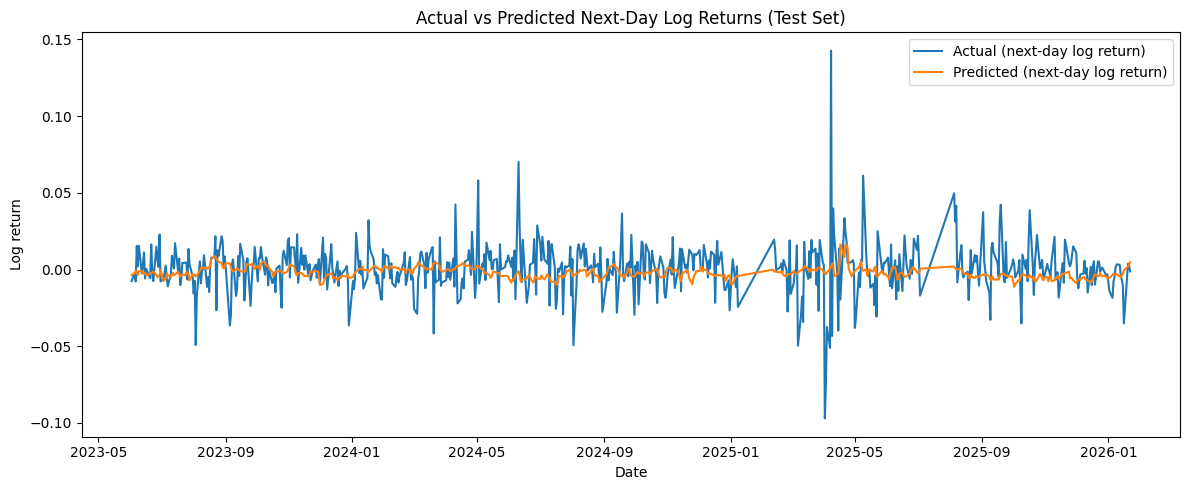

In [19]:
#cell 14: load predictions + plot (true vs predicted log return)
import pandas as pd
import matplotlib.pyplot as plt

pred_path = PROC_DIR / "phase2_artifacts" / "test_predictions.csv"
pred_df = pd.read_csv(pred_path)
pred_df["date"] = pd.to_datetime(pred_df["date"])
pred_df = pred_df.sort_values("date").reset_index(drop=True)

print("pred_df shape:", pred_df.shape)
display(pred_df.head())

plt.figure(figsize=(12, 5))
plt.plot(pred_df["date"], pred_df["y_true"], label="Actual (next-day log return)")
plt.plot(pred_df["date"], pred_df["y_pred"], label="Predicted (next-day log return)")
plt.title("Actual vs Predicted Next-Day Log Returns (Test Set)")
plt.xlabel("Date")
plt.ylabel("Log return")
plt.legend()
plt.tight_layout()
plt.show()


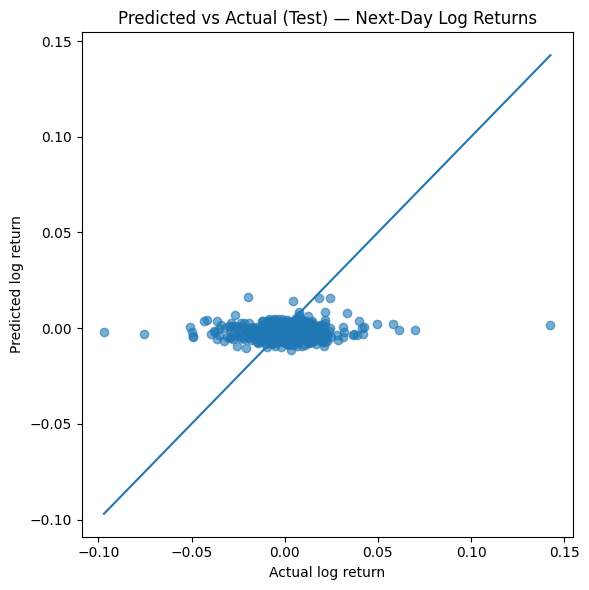

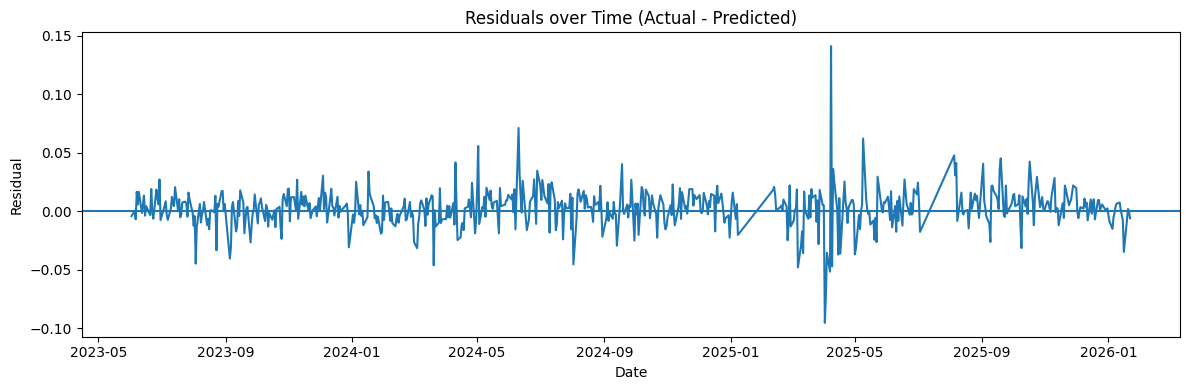

In [20]:
#cell 15: prediction diagnostics (scatter + residuals)
import numpy as np
import matplotlib.pyplot as plt

y_true = pred_df["y_true"].values.astype(float)
y_pred = pred_df["y_pred"].values.astype(float)
resid  = y_true - y_pred

#scatter: y_true vs y_pred
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims)  # 45-degree reference line
plt.title("Predicted vs Actual (Test) — Next-Day Log Returns")
plt.xlabel("Actual log return")
plt.ylabel("Predicted log return")
plt.tight_layout()
plt.show()

#residuals over time
plt.figure(figsize=(12, 4))
plt.plot(pred_df["date"], resid)
plt.axhline(0.0)
plt.title("Residuals over Time (Actual - Predicted)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()


In [23]:
#display all the values of pred_df
pd.set_option('display.max_rows', None)
print(pred_df)
pd.reset_option('display.max_rows')

          date    y_true    y_pred
0   2023-06-02 -0.007600 -0.003546
1   2023-06-05 -0.002062 -0.002391
2   2023-06-06 -0.007787 -0.000964
3   2023-06-07  0.015347 -0.001228
4   2023-06-08  0.002158 -0.003630
5   2023-06-09  0.015518 -0.001089
6   2023-06-12 -0.002615 -0.001154
7   2023-06-13  0.003485 -0.002715
8   2023-06-14  0.011136 -0.002262
9   2023-06-15 -0.005877 -0.002108
10  2023-06-16  0.000487 -0.004016
11  2023-06-20 -0.005692 -0.002443
12  2023-06-21  0.016390 -0.002614
13  2023-06-22 -0.001713 -0.001963
14  2023-06-23 -0.007582 -0.001239
15  2023-06-26  0.014947 -0.003566
16  2023-06-27  0.006308 -0.005029
17  2023-06-28  0.001795 -0.004060
18  2023-06-29  0.022840 -0.004291
19  2023-06-30 -0.007815 -0.000301
20  2023-07-03 -0.005889 -0.007485
21  2023-07-05  0.002505 -0.006025
22  2023-07-06 -0.005909 -0.002684
23  2023-07-07 -0.010915 -0.003566
24  2023-07-10 -0.002814 -0.004999
25  2023-07-11  0.008945 -0.003317
26  2023-07-12  0.004049 -0.002171
27  2023-07-13  0.00

In [24]:
#cell A: prediction sanity checks + summary stats
import numpy as np
import pandas as pd

pred_df = pred_df.copy()
pred_df["date"] = pd.to_datetime(pred_df["date"])
pred_df = pred_df.sort_values("date").reset_index(drop=True)

yt = pred_df["y_true"].to_numpy(dtype=float)
yp = pred_df["y_pred"].to_numpy(dtype=float)

def _stats(x):
    return {
        "mean": float(np.mean(x)),
        "std":  float(np.std(x)),
        "min":  float(np.min(x)),
        "max":  float(np.max(x)),
    }

print("y_true stats:", _stats(yt))
print("y_pred stats:", _stats(yp))
print("std ratio (pred/true):", float(np.std(yp) / (np.std(yt) + 1e-12)))

corr = float(np.corrcoef(yt, yp)[0, 1])
print("corr(y_true, y_pred):", corr)

#direction accuracy (MDA)
mda = float(np.mean((yt > 0) == (yp > 0)))
print("MDA:", mda)


y_true stats: {'mean': 0.0006103455186045991, 'std': 0.016329242618266373, 'min': -0.0970134247476801, 'max': 0.1426175164544219}
y_pred stats: {'mean': -0.002013146156264864, 'std': 0.0035173971582528906, 'min': -0.0113145932555198, 'max': 0.01651231944561}
std ratio (pred/true): 0.21540479495986065
corr(y_true, y_pred): 0.04954987441374334
MDA: 0.4854838709677419


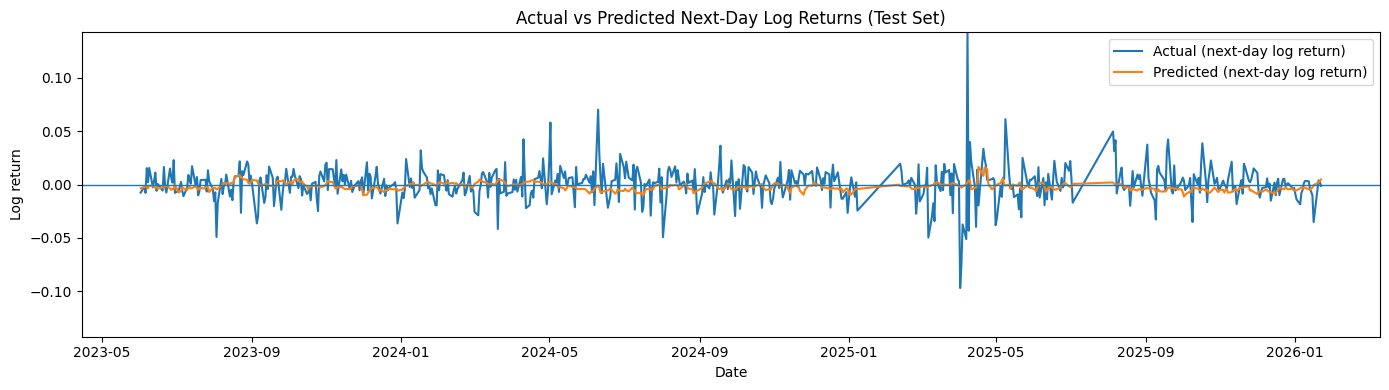

In [25]:
#cell B: plot actual vs predicted (same scale)
import matplotlib.pyplot as plt
import numpy as np

d = pred_df["date"]
yt = pred_df["y_true"].to_numpy(dtype=float)
yp = pred_df["y_pred"].to_numpy(dtype=float)

#symmetric y-limits so the scale is identical for both
lim = float(np.max(np.abs(np.concatenate([yt, yp]))))
lim = max(lim, 1e-6)

plt.figure(figsize=(14, 4))
plt.plot(d, yt, label="Actual (next-day log return)")
plt.plot(d, yp, label="Predicted (next-day log return)")
plt.axhline(0.0, linewidth=1)
plt.ylim(-lim, lim)
plt.title("Actual vs Predicted Next-Day Log Returns (Test Set)")
plt.xlabel("Date")
plt.ylabel("Log return")
plt.legend()
plt.tight_layout()
plt.show()


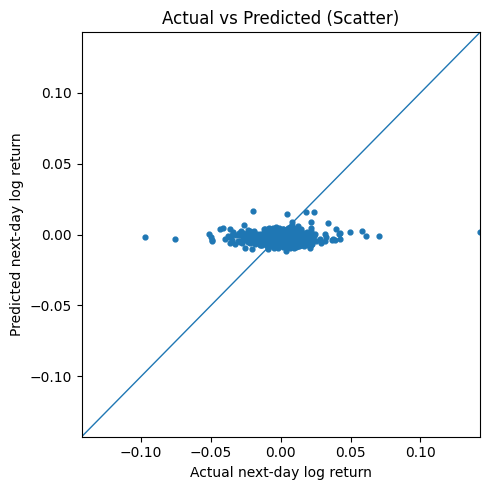

In [26]:
#cell C: scatter actual vs predicted
import matplotlib.pyplot as plt
import numpy as np

yt = pred_df["y_true"].to_numpy(dtype=float)
yp = pred_df["y_pred"].to_numpy(dtype=float)

lim = float(np.max(np.abs(np.concatenate([yt, yp]))))
lim = max(lim, 1e-6)

plt.figure(figsize=(5, 5))
plt.scatter(yt, yp, s=12)
plt.plot([-lim, lim], [-lim, lim], linewidth=1)  # y=x reference
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.title("Actual vs Predicted (Scatter)")
plt.xlabel("Actual next-day log return")
plt.ylabel("Predicted next-day log return")
plt.tight_layout()
plt.show()
